In [ ]:
#!pip install catboost
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [307]:
#!pip install pydot

In [308]:
#!pip install graphviz

In [290]:
import numpy as np
import pandas as pd
import librosa #Для параметризации аудио
import librosa.display
#import librosa.logamplitude

import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoostClassifier, Pool, metrics, cv

from tensorflow.keras.models import Sequential # save_model #Сеть прямого распространения
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, GRU, Input, concatenate, Activation
from tensorflow.keras.optimizers import SGD, Adam, Adadelta # оптимизаторы
from tensorflow.keras.models import Model

from tensorflow.keras import utils #Утилиты для to_categorical
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,EarlyStopping 

from tqdm import tqdm_notebook

import IPython.display as ipd #Для проигрывания аудио

import warnings
warnings.filterwarnings('ignore')

In [2]:
main_path = 'D:/ESC-50-master/ESC-50-master/audio/'
data_info = pd.read_csv('D:/ESC-50-master/ESC-50-master/meta/esc50.csv')

In [3]:
data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [4]:
data_info['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [ ]:
data_info.drop(['esc10','src_file','take'], axis=1, inplace=True)

In [ ]:
data_info.head()

In [5]:
sort_data = data_info.sort_values(by='target')

In [6]:
sort_data['category'].unique()

array(['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects',
       'sheep', 'crow', 'rain', 'sea_waves', 'crackling_fire', 'crickets',
       'chirping_birds', 'water_drops', 'wind', 'pouring_water',
       'toilet_flush', 'thunderstorm', 'crying_baby', 'sneezing',
       'clapping', 'breathing', 'coughing', 'footsteps', 'laughing',
       'brushing_teeth', 'snoring', 'drinking_sipping', 'door_wood_knock',
       'mouse_click', 'keyboard_typing', 'door_wood_creaks',
       'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm',
       'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren',
       'car_horn', 'engine', 'train', 'church_bells', 'airplane',
       'fireworks', 'hand_saw'], dtype=object)

In [7]:
#Загрузаем аудио
audio_path = 'D:/ESC-50-master/ESC-50-master/audio/1-5996-A-6.wav'

x, sr = librosa.load(audio_path, sr=44100, duration=5) #x - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
#Выводим данные по сигналу
print(type(x), type(sr))
print(x.shape[0], '- Всего значений')
print(sr, '- Частота дискритизации (зн/сек)')
print(x.shape[0]/sr, '- Длительность (сек)')

<class 'numpy.ndarray'> <class 'int'>
220500 - Всего значений
44100 - Частота дискритизации (зн/сек)
5.0 - Длительность (сек)


In [8]:
os.path.basename(audio_path)

'1-5996-A-6.wav'

In [9]:
class1 = data_info['category'][data_info.filename == os.path.basename(audio_path)].values[0]

In [10]:
class1

'hen'

In [147]:
ipd.Audio(audio_path)

# Feature Engineering

In [ ]:
########################################################################
# Функция получения фичей путём расчёта среднего по ряду значений каждой. 
########################################################################

def get_features_37(y, sr):

    '''
    Input:
        y - wave значений текущего трека 
        sr - частота дискретизации

    Output:
        np.array(out) - массив фичей текущего трека (37,)
    '''    
   
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)      #Частота цветности (по умолчанию 12 баков цветности)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)                    #Мел кепстральные коэффициенты (по умолчанию 20)
  
    rmse = np.mean(librosa.feature.rms(y=y))                           #Среднеквадратичная амплитуда
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))  #среднее ширины полосы частот
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))    #среднее спектрального спада частоты
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))               #среднее частота пересечения нуля звукового временного ряда
  
  
    #Добавляем все параметры в один список
    out = [] 
    out.append(rmse) 
    out.append(spec_cent) 
    out.append(spec_bw) 
    out.append(rolloff) 
    out.append(zcr) 
  
    #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
    for e in mfcc:
        out.append(np.mean(e))

    #добавляем среднее всех Частот цветности (12 значений)
    for e in chroma_stft:
        out.append(np.mean(e))
  
    return np.array(out)

In [ ]:
#####################################################################################################
# Функция получения фичей из mfcc и zcr путём расчёта среднего и среднего квадратического отклонения.
#####################################################################################################

def get_features_42(y, sr):

    '''
    Input:
        y - wave значений текущего трека 
        sr - частота дискретизации

    Output:
        np.array(out) - массив фичей текущего трека (42,)
    '''     
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr) 
  
    zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y)) 
    zcr_std = np.std(librosa.feature.zero_crossing_rate(y)) 

    #Добавляем все параметры в один список
    out = [] 

    out.append(zcr_mean) 
    out.append(zcr_std) 
    
    #добавляем mean всех Мел спектральных коэффициентов (20 значений)
    for e in mfcc:
        out.append(np.mean(e))
    
    #добавляем std всех Мел спектральных коэффициентов (20 значений)
    for e in mfcc:
        out.append(np.std(e))   
  
    return np.array(out)

In [ ]:
###########################################################
# Функция получения фичей из zcr и спектрального центроида.
###########################################################

def get_features_ZCR_SC(y, sr):

    '''
    Input:
        y - wave значений текущего трека 
        sr - частота дискретизации

    Output:
        one_vec1 - сконкатинированный одномерный массив фичей
    '''    
    
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)     #среднее спектральныго центроида
    spec_cent = spec_cent.reshape(spec_cent.shape[1])             # (1,N) -> (N,)   
    spec_cent_std = np.std(spec_cent) 
    one_vec1 = np.concatenate((spec_cent, np.array([spec_cent_std])), axis = 0) # (N,) + (i,)
    
    
    zcr = librosa.feature.zero_crossing_rate(y) #среднее частота пересечения нуля звукового временного ряда
    zcr = zcr.reshape(zcr.shape[1])             # (1,N) -> (N,)
    zcr_std = np.std(zcr)                       # zcr ряда
    one_vec2 = np.concatenate((zcr, np.array([zcr_std])), axis = 0) # (N,) + (i,)
    
    one_vec1 = np.concatenate((one_vec1, one_vec2), axis = 0 )
     
    # Возвращаем вектор обоих рядов обоих фичей
    return one_vec1

In [ ]:
#################################################################
# Функция получения фичей из stft, zcr и спектрального центроида.
#################################################################

def get_features_stft_zcr_sc(y, sr):

    '''
    Input:
        y - wave значений текущего трека 
        sr - частота дискретизации

    Output:
        one_vec - сконкатинированный одномерный массив фичей
    '''  
    
    spectr = librosa.stft(y=y)
    spectr_std = np.std(spectr, axis=0)
       
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)     #среднее спектральныго центроида
    spec_cent = spec_cent.reshape(spec_cent.shape[1])             # (1,N) -> (N,)   
   
    zcr = librosa.feature.zero_crossing_rate(y) #среднее частота пересечения нуля звукового временного ряда
    zcr = zcr.reshape(zcr.shape[1])             # (1,N) -> (N,)
  
    one_vec = np.concatenate((spectr_std, spec_cent), axis = 0)
    one_vec = np.concatenate((one_vec, zcr), axis = 0) 
     
    # Возвращаем вектор обоих рядов обоих фичей
    return one_vec    
    

In [85]:
#################################################################
# Функция создания датасета по выбранной функции получения фичей.
#################################################################

def get_samples(data_info, feature_func, main_path, sr, duration):
    
    '''
    Input:
        data_info - DataFrame с информацией о данных 
        feature_func - функция получения фичей
        main_path - директория, где распологаются все аудио примеры
        sr - частота дискретизации 
        duration - длина трека, которую хочим получить (сек)
        
    Output:
        np.array(Samples) - сформированный датасет
    '''    
    
    Samples = []
    
    for index in tqdm_notebook(range(data_info.shape[0])):

        x, sr = librosa.load(f'{main_path}{data_info.values[index,0]}', sr=sr, duration=duration)
        
        sample = feature_func(x, sr)
        Samples.append(np.array(sample))
    
    return np.array(Samples)
     

### Визуализация частоты цветности

In [94]:
chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)

In [141]:
chroma_stft.shape

(12, 431)

In [142]:
test = chroma_stft.reshape((431*12))

In [143]:
test.shape

(5172,)

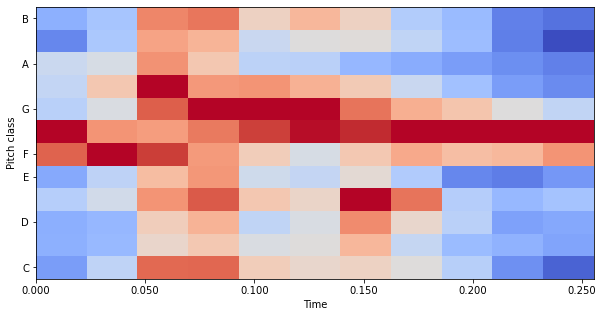

In [144]:
chromagram = librosa.feature.chroma_stft(test, sr=sr)
plt.figure(figsize=(10, 5))# Зададим размер графика
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm') 

plt.show()# Выведем график

### Визуализация спектрограммы

In [148]:
spectr = librosa.stft(y=x)

In [149]:
spectr.shape

(1025, 431)

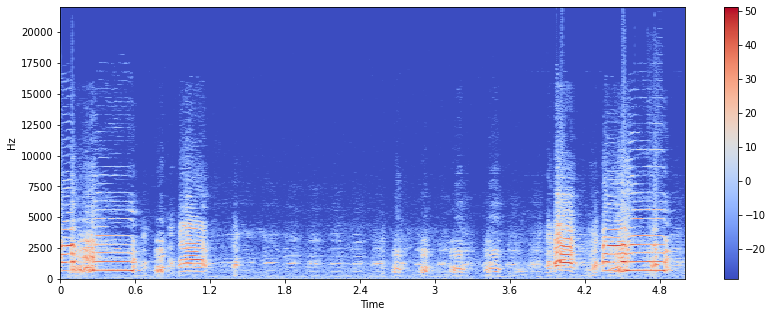

In [150]:
Xdb = librosa.amplitude_to_db(abs(spectr))

plt.figure(figsize=(14, 5))#задаем размер

librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',) #Отобразим спектрограммы
plt.colorbar()#выведем цветовую шкалу
plt.show()#выводим график

# Создание датасетов

In [118]:
#################################################################################################
# Формироваеие датасета несвязанных данных для обучения на классических алгоритмах и Dense сетях.
#################################################################################################

Samples_37 = get_samples(data_info, get_features_37, main_path)

C:\Users\user\AppData\Local\Temp/ipykernel_10228/3711981826.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(range(data_info.shape[0])):


  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
#np.savetxt('C:/Users/user/Desktop/Employers/EMBLE/37_features.txt', Samples_37, delimiter=',')

In [49]:
#################################################################################################
# Формироваеие датасета несвязанных данных для обучения на классических алгоритмах и Dense сетях.
#################################################################################################

Samples_42 = get_samples(data_info, get_features_42, main_path)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [51]:
#np.savetxt('C:/Users/user/Desktop/Employers/EMBLE/42_features.txt', Samples_42, delimiter=',')

In [10]:
#######################################################################
# Формироваеие датасета связанных данных для обучения на сверточных НС.
#######################################################################

Samples_ZCR_SC = get_samples(data_info, get_features_ZCR_SC, main_path, 16000, 3)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
#np.savetxt('C:/Users/user/Desktop/Employers/EMBLE/ZCR_SC_features.txt', Samples_ZCR_SC, delimiter=',')

In [197]:
#######################################################################
# Формироваеие датасета связанных данных для обучения на сверточных НС.
#######################################################################

Samples_chr_zcr_sc = get_samples(data_info, get_features_stft_zcr_sc, main_path, 16000, 3)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [198]:
#np.savetxt('C:/Users/user/Desktop/Employers/EMBLE/Chr_zcr_sc_features.txt', Samples_chr_zcr_sc, delimiter=',')

# Modelling Classic Algorithms

In [4]:
#############################################################################
# Функция оценки моделей на 5 фолдах при изменении некоторых гиперпараметров.
#############################################################################

def train_test(cl_name, Samples_load, data_name, need_scale):

    '''
    Input:
        cl_name - имя текущего классификатора 
        Samples_load - текущий датасет
        data_name - имя текущего датасета (str)
        need_scale - флаг нормализации (True - данные будут нормализованы)
    '''  
    
    if need_scale == True:       
        Scaler = StandardScaler()
        Samples_load = Scaler.fit_transform(Samples_load)        

    '''-----------------------------knn---------------------------------'''        
    if cl_name == 'knn':
        print(f'--{cl_name}--{data_name}--Scale:{need_scale}')      
        max_acc = []
        
        for n in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
            acc_av = []
    
            for fold in range(1,6):       
                x_train = Samples_load[data_info.fold != fold]
                y_train = data_info[data_info.fold != fold].category

                x_test = Samples_load[data_info.fold == fold]
                y_test = data_info[data_info.fold == fold].category        

                knn = KNeighborsClassifier(n_neighbors=n) # изменяем кол-во соседей
                knn.fit(x_train,y_train)

                test_pred = knn.predict(x_test)
                accuracy = np.sum(y_test == test_pred) / float(test_pred.shape[0])

                acc_av.append(accuracy)
                
#                print(f'Фолд: {fold}, Точность - {accuracy}, neighbors={n}')        
            
            acc_av = np.array(acc_av)
            accuracy = acc_av.sum()/5
            max_acc.append(accuracy.max())
            
            print(f'Точность - {round(accuracy, 4)}, число соседей - {n}')

    '''-----------------------------RF---------------------------------'''                   
    if cl_name == 'RF':
        print(f'--{cl_name}--{data_name}--Scale:{need_scale}')      
        max_acc = []           
            
        for n in [50, 100, 150, 200, 250]:
            acc_av = []
    
            for fold in range(1,6):       
                x_train = Samples_load[data_info.fold != fold]
                y_train = data_info[data_info.fold != fold].category

                x_test = Samples_load[data_info.fold == fold]
                y_test = data_info[data_info.fold == fold].category        

                RF = RandomForestClassifier(n_estimators=n, random_state=42)
                RF.fit(x_train,y_train)

                test_pred = RF.predict(x_test)               
                accuracy = np.sum(y_test == test_pred) / float(test_pred.shape[0])

                acc_av.append(accuracy)   
            
            acc_av = np.array(acc_av)
            accuracy = acc_av.sum()/5
            max_acc.append(accuracy.max())
            
            print(f'Точность - {round(accuracy, 4)}, число trees - {n}')

            
    '''-----------------------------SVM---------------------------------'''                   
    if cl_name == 'SVM':
        print(f'--{cl_name}--{data_name}--Scale:{need_scale}')      
        max_acc = []           
            
        for n in np.arange(0.02, 0.1, 0.01):
            acc_av = []
    
            for fold in range(1,6):       
                x_train = Samples_load[data_info.fold != fold]
                y_train = data_info[data_info.fold != fold].category

                x_test = Samples_load[data_info.fold == fold]
                y_test = data_info[data_info.fold == fold].category        

                svm = SVC(C=n, kernel='linear', random_state=42)
                svm.fit(x_train,y_train)

                test_pred = svm.predict(x_test)
                accuracy = np.sum(y_test == test_pred) / float(test_pred.shape[0])


                acc_av.append(accuracy)   
            
            acc_av = np.array(acc_av)
            accuracy = acc_av.sum()/5
            max_acc.append(accuracy.max())
            
            print(f'Точность - {round(accuracy, 4)}, Regularization parameter - {n}')            
            
    '''-----------------------------LR---------------------------------'''                   
    if cl_name == 'LR':
        print(f'--{cl_name}--{data_name}--Scale:{need_scale}')      
        max_acc = []           
            
        for n in np.arange(2, 9, 2):
            acc_av = []
    
            for fold in range(1,6):       
                x_train = Samples_load[data_info.fold != fold]
                y_train = data_info[data_info.fold != fold].category

                x_test = Samples_load[data_info.fold == fold]
                y_test = data_info[data_info.fold == fold].category        

                LR = LogisticRegressionCV(cv=n)
                LR.fit(x_train,y_train)

                test_pred = LR.predict(x_test)
                accuracy = np.sum(y_test == test_pred) / float(test_pred.shape[0])


                acc_av.append(accuracy)   
            
            acc_av = np.array(acc_av)
            accuracy = acc_av.sum()/5
            max_acc.append(accuracy.max())
            
            print(f'Точность - {round(accuracy, 4)}, Number of folds  - {n}')   
            
            
            
            
    print(max(max_acc), '- максимальная точность')       
    print()

# knn

In [5]:
Samples_load_37 = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/37_features.txt',delimiter=',')
Samples_load_42 = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/42_features.txt',delimiter=',')

In [7]:
train_test('knn', Samples_load_37, '37_features', False)
train_test('knn', Samples_load_37, '37_features', True)
train_test('knn', Samples_load_42, '42_features', False)
train_test('knn', Samples_load_42, '42_features', True)

--knn--37_features--Scale:False
Точность - 0.0965, число соседей - 2
Точность - 0.1025, число соседей - 3
Точность - 0.1, число соседей - 4
Точность - 0.107, число соседей - 5
Точность - 0.111, число соседей - 6
Точность - 0.113, число соседей - 7
Точность - 0.1225, число соседей - 8
Точность - 0.1275, число соседей - 9
Точность - 0.1295, число соседей - 10
0.1295 - максимальная точность

--knn--37_features--Scale:True
Точность - 0.2455, число соседей - 2
Точность - 0.2615, число соседей - 3
Точность - 0.2675, число соседей - 4
Точность - 0.269, число соседей - 5
Точность - 0.272, число соседей - 6
Точность - 0.2685, число соседей - 7
Точность - 0.2685, число соседей - 8
Точность - 0.2735, число соседей - 9
Точность - 0.272, число соседей - 10
0.2735 - максимальная точность

--knn--42_features--Scale:False
Точность - 0.245, число соседей - 2
Точность - 0.258, число соседей - 3
Точность - 0.2565, число соседей - 4
Точность - 0.2625, число соседей - 5
Точность - 0.2665, число соседей - 6

# RF

In [144]:
train_test('RF', Samples_load_37, '37_features', False)
train_test('RF', Samples_load_37, '37_features', True)
train_test('RF', Samples_load_42, '42_features', False)
train_test('RF', Samples_load_42, '42_features', True)

--RF--37_features--Scale:False
Точность - 0.3605, число trees - 50
Точность - 0.3825, число trees - 100
Точность - 0.3805, число trees - 150
Точность - 0.3885, число trees - 200
Точность - 0.388, число trees - 250
0.3885 - максимальная точность

--RF--37_features--Scale:True
Точность - 0.3605, число trees - 50
Точность - 0.3825, число trees - 100
Точность - 0.3805, число trees - 150
Точность - 0.3885, число trees - 200
Точность - 0.388, число trees - 250
0.3885 - максимальная точность

--RF--42_features--Scale:False
Точность - 0.427, число trees - 50
Точность - 0.448, число trees - 100
Точность - 0.4665, число trees - 150
Точность - 0.4785, число trees - 200
Точность - 0.48, число trees - 250
0.48 - максимальная точность

--RF--42_features--Scale:True
Точность - 0.427, число trees - 50
Точность - 0.448, число trees - 100
Точность - 0.4665, число trees - 150
Точность - 0.4785, число trees - 200
Точность - 0.48, число trees - 250
0.48 - максимальная точность



# svm

In [10]:
# Не может обработать НЕнормализованные значения

#train_test('SVM', Samples_load_37, '37_features', False)
train_test('SVM', Samples_load_37, '37_features', True)
#train_test('SVM', Samples_load_42, '42_features', False)
train_test('SVM', Samples_load_42, '42_features', True)

--SVM--37_features--Scale:True
Точность - 0.337, Regularization parameter - 0.02
Точность - 0.3575, Regularization parameter - 0.03
Точность - 0.361, Regularization parameter - 0.039999999999999994
Точность - 0.3645, Regularization parameter - 0.049999999999999996
Точность - 0.37, Regularization parameter - 0.06
Точность - 0.3695, Regularization parameter - 0.06999999999999999
Точность - 0.375, Regularization parameter - 0.07999999999999999
Точность - 0.372, Regularization parameter - 0.09
0.375 - максимальная точность

--SVM--42_features--Scale:True
Точность - 0.432, Regularization parameter - 0.02
Точность - 0.4395, Regularization parameter - 0.03
Точность - 0.4545, Regularization parameter - 0.039999999999999994
Точность - 0.4505, Regularization parameter - 0.049999999999999996
Точность - 0.4585, Regularization parameter - 0.06
Точность - 0.4615, Regularization parameter - 0.06999999999999999
Точность - 0.4595, Regularization parameter - 0.07999999999999999
Точность - 0.455, Regular

# LR

In [6]:
#train_test('LR', Samples_load_37, '37_features', False)
train_test('LR', Samples_load_37, '37_features', True)
#train_test('LR', Samples_load_42, '42_features', False)
train_test('LR', Samples_load_42, '42_features', True)

--LR--37_features--Scale:True
Точность - 0.401, Number of folds  - 2
Точность - 0.401, Number of folds  - 4
Точность - 0.4015, Number of folds  - 6
Точность - 0.401, Number of folds  - 8
0.40149999999999997 - максимальная точность

--LR--42_features--Scale:True
Точность - 0.4595, Number of folds  - 2
Точность - 0.457, Number of folds  - 4
Точность - 0.4595, Number of folds  - 6
Точность - 0.4595, Number of folds  - 8
0.45949999999999996 - максимальная точность



# CatBoost

In [5]:
Samples_load_37 = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/37_features.txt',delimiter=',')
Samples_load_42 = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/42_features.txt',delimiter=',')

In [6]:
Samples_load = Samples_load_42

Scaler = StandardScaler()
Samples_load = Scaler.fit_transform(Samples_load)        

fold = 5

x_train = Samples_load[data_info.fold != fold]
y_train = data_info[data_info.fold != fold].category

x_test = Samples_load[data_info.fold == fold]
y_test = data_info[data_info.fold == fold].category

'''    
for fold in range(1,6):       
    x_train = Samples_load[data_info.fold != fold]
    y_train = data_info[data_info.fold != fold].category

    x_test = Samples_load[data_info.fold == fold]
    y_test = data_info[data_info.fold == fold].category
'''
print()

In [7]:
###################
# Создаем CAtBoost.
###################

model_cat_1 = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=500
)

In [8]:
###################################
# Обучение CAtBoost классификатора.
###################################

model_cat_1.fit(
    x_train, y_train,
#    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
#    logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
    use_best_model=True,
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

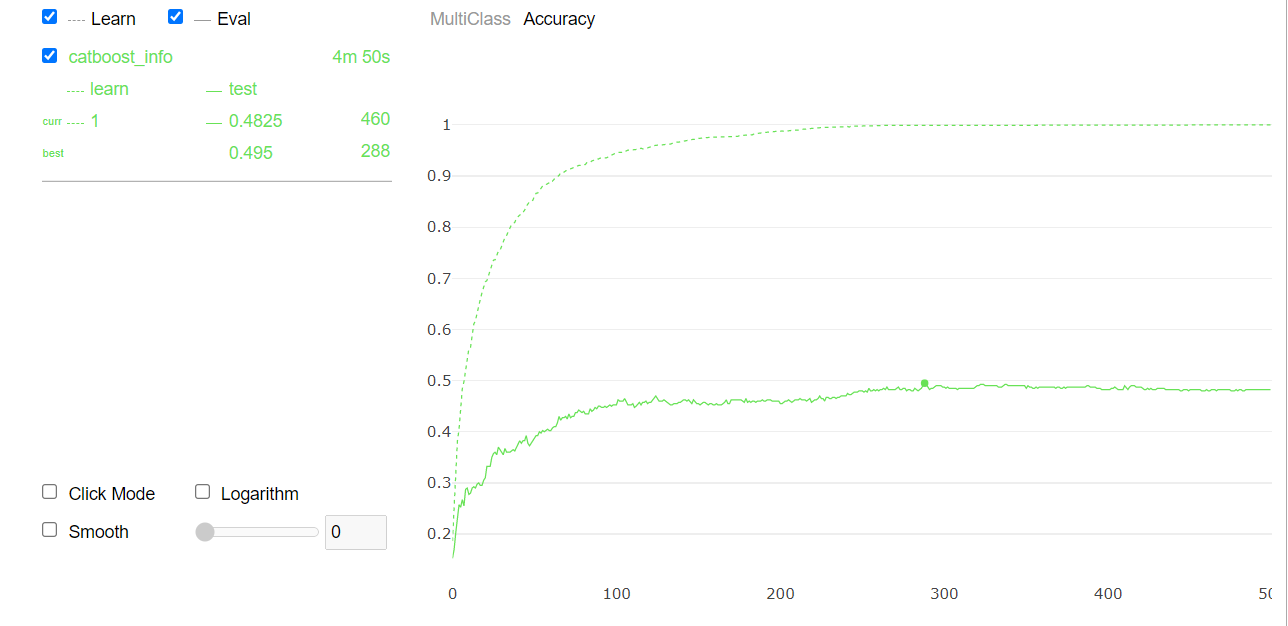

In [9]:
predict_1 = model_cat_1.predict(x_test)

In [10]:
print(classification_report(y_test, predict_1))

                  precision    recall  f1-score   support

        airplane       0.56      0.62      0.59         8
       breathing       0.67      0.50      0.57         8
  brushing_teeth       0.78      0.88      0.82         8
     can_opening       0.38      0.38      0.38         8
        car_horn       0.57      0.50      0.53         8
             cat       0.56      0.62      0.59         8
        chainsaw       0.22      0.25      0.24         8
  chirping_birds       0.40      0.25      0.31         8
    church_bells       0.62      0.62      0.62         8
        clapping       0.40      0.25      0.31         8
     clock_alarm       0.75      0.75      0.75         8
      clock_tick       0.38      0.38      0.38         8
        coughing       0.56      0.62      0.59         8
             cow       0.67      0.25      0.36         8
  crackling_fire       0.67      0.25      0.36         8
        crickets       0.45      0.62      0.53         8
            c

# Подытог

## knn - 0.3465 

## LR - 0.4594 

## SVM - 0.4615 

## RF - 0.48 

## CB - 0.495





# KERAS (Deep Learning)

## Preprocessing

In [67]:
Samples_load_37 = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/37_features.txt',delimiter=',')
Samples_load_42 = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/42_features.txt',delimiter=',')

In [68]:
Samples_load = Samples_load_42

Scaler = StandardScaler()
Samples_load = Scaler.fit_transform(Samples_load)        


In [69]:
Samples_load.shape

(2000, 42)

In [70]:
fold = 5

x_train = Samples_load[data_info.fold != fold]
y_train = data_info[data_info.fold != fold].target

x_test = Samples_load[data_info.fold == fold]
y_test = data_info[data_info.fold == fold].target

In [71]:
y_train

0        0
1       14
2       36
3       36
4       19
        ..
1595     4
1596     4
1597     4
1598     4
1599     4
Name: target, Length: 1600, dtype: int64

In [72]:
x_train.shape

(1600, 42)

In [73]:
######################################
# перефодим наши targets в формат OHE.
######################################

y_train_ohe = utils.to_categorical(y_train.values, 50)
print(y_train_ohe[0])

y_test_ohe = utils.to_categorical(y_test.values, 50)
print(y_test_ohe[0])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


# Dense

In [108]:
#################
# гиперпараметры
#################

batch_size = 10 
epochs = 300
input_shape = x_train.shape[1:]


#####################################################
# Функция построения модели прототипа классификатора
#####################################################

def model():
    model = Sequential()                                    # Создаем последовательную модель      

    model.add(Dense(units=32, activation='relu', input_shape = input_shape)) 
    model.add(Dropout(0.2))    
    model.add(Dense(32, activation='relu'))                 
    model.add(Dropout(0.2))                                
    model.add(Dense(50, activation='softmax'))               

    #Компилируем сеть
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

    return model



In [109]:
model_1 = model()

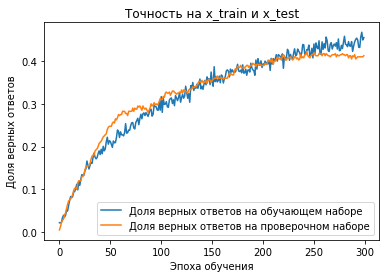

In [110]:
##############
# обучение НС
##############
lr_list = []

history = model_1.fit(x_train, 
                    y_train_ohe, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test_ohe),
                    verbose=0, 
                    shuffle=True,)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

In [112]:
max(history.history['val_accuracy'])

0.42250001430511475

In [23]:
#################
# гиперпараметры
#################

batch_size = 32 
epochs = 300
input_shape = x_train.shape[1:]


#####################################################
# Функция построения модели прототипа классификатора
#####################################################

def model():
    model = Sequential()                                    # Создаем последовательную модель      

    model.add(Dense(units=64, activation='relu', input_shape = input_shape)) 
    model.add(Dropout(0.2))    
    model.add(Dense(64, activation='relu'))                
    model.add(Dropout(0.2))                                
    model.add(Dense(50, activation='softmax'))              

    #Компилируем сеть
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

    return model



In [24]:
model_1 = model()

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

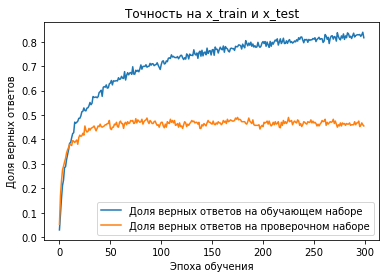

In [25]:
##############
# обучение НС
##############
lr_list = []

history = model_1.fit(x_train, 
                    y_train_ohe, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test_ohe),
                    verbose=10, 
                    shuffle=True,)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

In [27]:
max(history.history['val_accuracy'])

0.49000000953674316

In [186]:
#################
# гиперпараметры
#################

batch_size = 7 
epochs = 200
input_shape = x_train.shape[1:]


#####################################################
# Функция построения модели прототипа классификатора
#####################################################

def model():
    model = Sequential()                                    # Создаем последовательную модель      

    model.add(Dense(units=256, activation='relu', input_shape = input_shape)) 
    model.add(Dropout(0.3))    
    model.add(Dense(256, activation='relu'))                 
    model.add(Dropout(0.25))                               
    model.add(Dense(32, activation='relu'))                 
    model.add(Dense(50, activation='softmax'))              

    #Компилируем сеть
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

    return model



In [187]:
model_1 = model()

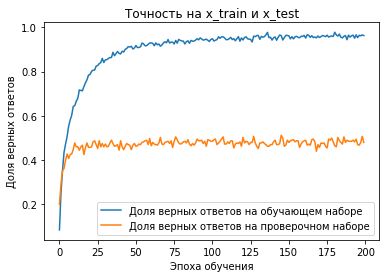

In [188]:
##############
# обучение НС
##############
lr_list = []

history = model_1.fit(x_train, 
                    y_train_ohe, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test_ohe),
                    verbose=0, 
                    shuffle=True,)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

In [189]:
max(history.history['val_accuracy'])

0.512499988079071

# Conv

## На датасете ZCR_SC_features

In [199]:
Samples_load_ZCR_SC = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/ZCR_SC_features.txt',delimiter=',')
print(Samples_load_ZCR_SC.shape)

Samples_load = Samples_load_ZCR_SC

Scaler = StandardScaler()
Samples_load = Scaler.fit_transform(Samples_load)        

fold = 5

x_train = Samples_load[data_info.fold != fold]
y_train = data_info[data_info.fold != fold].target

x_test = Samples_load[data_info.fold == fold]
y_test = data_info[data_info.fold == fold].target

######################################
# перефодим наши targets в формат OHE.
######################################

y_train_ohe = utils.to_categorical(y_train.values, 50)
print(y_train_ohe[0])

y_test_ohe = utils.to_categorical(y_test.values, 50)
print(y_test_ohe[0])


(2000, 190)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [40]:

path = 'C:/Users/user/Desktop/Employers/EMBLE/'

def create_call(name_model):
    
    checkpoint = ModelCheckpoint(path + name_model, verbose=1, monitor='val_log_cosh', save_best_only=True, mode='auto')
    earlystop = EarlyStopping(monitor='val_log_cosh', patience=10, restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    
    return callbacks_list

In [18]:
x_train.shape

(1600, 190)

In [66]:
input_shape_conv = (190, 1)

def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(16, 3, input_shape = input_shape_conv, activation="relu"))
    modelC.add(Conv1D(16, 3, activation="relu"))
    modelC.add(MaxPooling1D())
    
    modelC.add(Conv1D(32, 3, activation="relu"))
    modelC.add(Conv1D(32, 3, activation="relu"))
#    modelC.add(MaxPooling1D())
    
    modelC.add(Flatten())
    
#    modelC.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))

    modelC.add(Dense(512, activation="relu"))
    modelC.add(Dropout(0.15))
    modelC.add(Dense(50, activation="softmax"))

    # компиляция модели

    modelC.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    modelC.summary()
    
    return modelC



In [ ]:
model_C1 = conv_model()

In [63]:
callbacks_list = create_call('model_C1')

Epoch 1/25
16/16 [==============================] - 2s 70ms/step - loss: 3.8073 - accuracy: 0.0356 - val_loss: 3.6137 - val_accuracy: 0.0725
Epoch 2/25
16/16 [==============================] - 1s 55ms/step - loss: 3.4994 - accuracy: 0.1000 - val_loss: 3.4832 - val_accuracy: 0.1000
Epoch 3/25
16/16 [==============================] - 1s 57ms/step - loss: 3.2260 - accuracy: 0.1619 - val_loss: 3.3666 - val_accuracy: 0.1550
Epoch 4/25
16/16 [==============================] - 1s 58ms/step - loss: 2.9387 - accuracy: 0.2169 - val_loss: 3.3030 - val_accuracy: 0.1450
Epoch 5/25
16/16 [==============================] - 1s 64ms/step - loss: 2.6573 - accuracy: 0.2650 - val_loss: 3.2970 - val_accuracy: 0.1675
Epoch 6/25
16/16 [==============================] - 1s 60ms/step - loss: 2.3893 - accuracy: 0.3156 - val_loss: 3.2914 - val_accuracy: 0.1625
Epoch 7/25
16/16 [==============================] - 1s 60ms/step - loss: 2.1439 - accuracy: 0.3781 - val_loss: 3.3978 - val_accuracy: 0.1625
Epoch 8/25
16

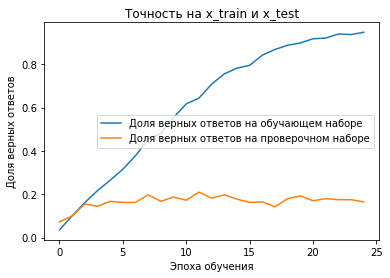

In [64]:
#################
# гиперпараметры
#################

batch_size = 100 
epochs = 25


##############
# обучение НС
##############
lr_list = []

history = model_C1.fit(x_train, 
                    y_train_ohe, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test_ohe),
                    verbose=1, 
                    shuffle=True)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

# На датасете - Chr_zcr_sc_features!

In [200]:
Samples_load_Chr_zcr_sc = np.loadtxt('C:/Users/user/Desktop/Employers/EMBLE/Chr_zcr_sc_features.txt',delimiter=',')
print(Samples_load_Chr_zcr_sc.shape)

Samples_load = Samples_load_Chr_zcr_sc

Scaler = StandardScaler()
Samples_load = Scaler.fit_transform(Samples_load)        

fold = 5

x_train = Samples_load[data_info.fold != fold]
y_train = data_info[data_info.fold != fold].target

x_test = Samples_load[data_info.fold == fold]
y_test = data_info[data_info.fold == fold].target

######################################
# перефодим наши targets в формат OHE.
######################################

y_train_ohe = utils.to_categorical(y_train.values, 50)
print(y_train_ohe[0])

y_test_ohe = utils.to_categorical(y_test.values, 50)
print(y_test_ohe[0])


(2000, 282)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [203]:
x_train.shape

(1600, 282)

In [204]:

path = 'C:/Users/user/Desktop/Employers/EMBLE/'

def create_call(name_model):
    
    checkpoint = ModelCheckpoint(path + name_model, verbose=1, monitor='val_log_cosh', save_best_only=True, mode='auto')
    earlystop = EarlyStopping(monitor='val_log_cosh', patience=10, restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    
    return callbacks_list

In [269]:
input_shape_conv = (x_train.shape[1], 1)

def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(32, 5, input_shape = input_shape_conv, activation="relu", padding='same'))
    modelC.add(Conv1D(32, 5, activation="relu", padding='same') )
    modelC.add(MaxPooling1D())
    
    modelC.add(Conv1D(32, 3, activation="relu", padding='same'))
    modelC.add(Conv1D(32, 3, activation="relu", padding='same'))
#    modelC.add(MaxPooling1D())
    
    modelC.add(GRU(32, dropout=0.25, recurrent_dropout=0.25, activation="relu"))
    
    modelC.add(Flatten())
    

#    modelC.add(Dense(128, activation="relu"))
#    modelC.add(Dropout(0.15))
    modelC.add(Dense(50, activation="softmax"))

    # компиляция модели

    modelC.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    modelC.summary()
    
    return modelC



In [270]:
callbacks_list = create_call('model_C2')

In [271]:
model_C2 = conv_model()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 282, 32)           192       
                                                                 
 conv1d_44 (Conv1D)          (None, 282, 32)           5152      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 141, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_45 (Conv1D)          (None, 141, 32)           3104      
                                                                 
 conv1d_46 (Conv1D)          (None, 141, 32)           3104      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                     

Epoch 1/50
100/100 [==============================] - 11s 88ms/step - loss: 3.8791 - accuracy: 0.0262 - val_loss: 3.8264 - val_accuracy: 0.0450
Epoch 2/50
100/100 [==============================] - 8s 82ms/step - loss: 3.7952 - accuracy: 0.0344 - val_loss: 3.7291 - val_accuracy: 0.0300
Epoch 3/50
100/100 [==============================] - 8s 80ms/step - loss: 3.7326 - accuracy: 0.0306 - val_loss: 3.7297 - val_accuracy: 0.0375
Epoch 4/50
100/100 [==============================] - 9s 91ms/step - loss: 3.6978 - accuracy: 0.0400 - val_loss: 3.7054 - val_accuracy: 0.0425
Epoch 5/50
100/100 [==============================] - 9s 92ms/step - loss: 3.6762 - accuracy: 0.0475 - val_loss: 3.6991 - val_accuracy: 0.0625
Epoch 6/50
100/100 [==============================] - 10s 102ms/step - loss: 3.6242 - accuracy: 0.0575 - val_loss: 3.6406 - val_accuracy: 0.0800
Epoch 7/50
100/100 [==============================] - 10s 96ms/step - loss: 3.5529 - accuracy: 0.0737 - val_loss: 3.6454 - val_accuracy: 0.

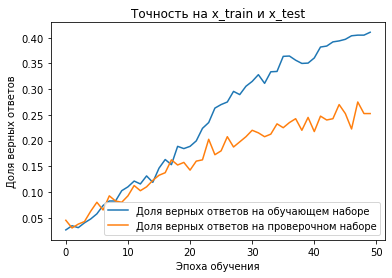

In [272]:
#################
# гиперпараметры
#################

batch_size = 16 # 16
epochs = 50


##############
# обучение НС
##############
lr_list = []

history = model_C2.fit(x_train, 
                    y_train_ohe, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test_ohe),
                    verbose=1, 
                    shuffle=True)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

**C GRU**

In [275]:
max(history.history['val_accuracy'])

0.2750000059604645

**Так же при обучении с GRU наблюдается растущий тренд точности**

**Без GRU**

In [245]:
max(history.history['val_accuracy'])

0.26249998807907104

# Сложная сеть 3 branch

In [278]:
input_shape_conv = (int(x_train.shape[1]/3), 1)
print(input_shape_conv)

(94, 1)


In [349]:
# x_train
x_train1 = x_train[:,:94]
x_train2 = x_train[:,94:94*2]
x_train3 = x_train[:,94*2:94*3]

# x_test
x_test1 = x_test[:,:94]
x_test2 = x_test[:,94:94*2]
x_test3 = x_test[:,94*2:94*3]

In [392]:
def Three_branch(num_classes = 50, input_shape= input_shape_conv):
    
    input_1 = Input(input_shape_conv)
    input_2 = Input(input_shape_conv)
    input_3 = Input(input_shape_conv)
    
    # Branch_one
    x1 = Conv1D(128, 5, padding='same', name='block1_conv1')(input_1) # Добавляем Conv2D-слой с 32-нейронами                                     
    x1 = Activation('relu')(x1)                                              # Добавляем слой Activation
    x1 = Conv1D(128, 5, padding='same', name='block1_conv2')(x1)         # Добавляем Conv2D-слой с 32-нейронами
    x1 = Activation('relu')(x1)  
    x1 = MaxPooling1D()(x1) 
    out_1 = GRU(64, dropout=0.25, recurrent_dropout=0.25, activation="relu")(x1) 

    # Branch_two
    x2 = Conv1D(128, 5, padding='same', name='block2_conv1')(input_2) # Добавляем Conv2D-слой с 32-нейронами
    x2 = Activation('relu')(x2)                                              # Добавляем слой Activation
    x2 = Conv1D(128, 5, padding='same', name='block2_conv2')(x2)         # Добавляем Conv2D-слой с 32-нейронами
    x2 = Activation('relu')(x2)  
    x2 = MaxPooling1D()(x2) 
    out_2 = GRU(64, dropout=0.25, recurrent_dropout=0.25, activation="relu")(x2)  
    
    # Branch_three
    x3 = Conv1D(128, 5, padding='same', name='block3_conv1')(input_3) # Добавляем Conv2D-слой с 32-нейронами   
    x3 = Activation('relu')(x3)                                              # Добавляем слой Activation
    x3 = Conv1D(128, 5, padding='same', name='block3_conv2')(x3)         # Добавляем Conv2D-слой с 32-нейронами
    x3 = Activation('relu')(x3)  
    x3 = MaxPooling1D()(x3) 
    out_3 = GRU(64, dropout=0.25, recurrent_dropout=0.25, activation="relu")(x3)  
    
    x = concatenate([out_1, out_2, out_3]) # Объединяем все три ветки 
    
    x = Flatten()(x)

#    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    model = Model((input_1, input_2, input_3), out) # В Model загружаем стартовые и последнюю точки 
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

In [393]:
tree_model = Three_branch()
type(tree_model)

keras.engine.functional.Functional

In [389]:
utils.plot_model(tree_model) # ???????

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Epoch 1/60
100/100 [==============================] - 24s 181ms/step - loss: 3.7249 - accuracy: 0.0481 - val_loss: 3.5567 - val_accuracy: 0.0775
Epoch 2/60
100/100 [==============================] - 17s 171ms/step - loss: 3.3794 - accuracy: 0.0919 - val_loss: 3.3687 - val_accuracy: 0.1225
Epoch 3/60
100/100 [==============================] - 17s 170ms/step - loss: 3.1575 - accuracy: 0.1369 - val_loss: 3.1760 - val_accuracy: 0.1475
Epoch 4/60
100/100 [==============================] - 17s 167ms/step - loss: 2.9290 - accuracy: 0.1787 - val_loss: 3.1047 - val_accuracy: 0.1725
Epoch 5/60
100/100 [==============================] - 17s 166ms/step - loss: 2.7517 - accuracy: 0.2344 - val_loss: 2.9376 - val_accuracy: 0.2175
Epoch 6/60
100/100 [==============================] - 17s 168ms/step - loss: 2.5903 - accuracy: 0.2650 - val_loss: 2.9141 - val_accuracy: 0.1925
Epoch 7/60
100/100 [==============================] - 16s 164ms/step - loss: 2.4249 - accuracy: 0.2875 - val_loss: 2.7901 - val_ac

100/100 [==============================] - 17s 168ms/step - loss: 0.3749 - accuracy: 0.8813 - val_loss: 4.1552 - val_accuracy: 0.3425
Epoch 58/60
100/100 [==============================] - 17s 169ms/step - loss: 0.4241 - accuracy: 0.8612 - val_loss: 4.3372 - val_accuracy: 0.3350
Epoch 59/60
100/100 [==============================] - 19s 191ms/step - loss: 0.4020 - accuracy: 0.8581 - val_loss: 4.3151 - val_accuracy: 0.3250
Epoch 60/60
100/100 [==============================] - 18s 183ms/step - loss: 0.3290 - accuracy: 0.8931 - val_loss: 4.3538 - val_accuracy: 0.3300


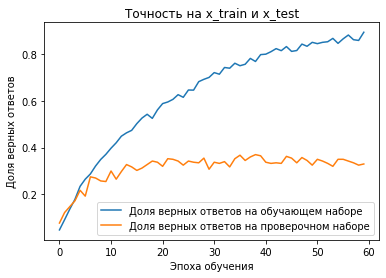

In [394]:
#################
# гиперпараметры
#################

batch_size = 16 # 16
epochs = 60

history = tree_model.fit([x_train1,x_train2,x_train3], 
                    y_train_ohe, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=([x_test1,x_test2,x_test3], y_test_ohe),
                    verbose=1, 
                    shuffle=True)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

In [395]:
max(history.history['val_accuracy'])

0.3700000047683716

## Выводы

- Максимальная точность в 0.5125 была достигнута на датасете Samples_load_42 (категориальные данные) с применением архитектуры полносвязной сети.
- Максимальная точность на связанных данных (датасет Chr_zcr_sc_features) была всего 0.37.

- Для повышения точности предсказания на сложных связанных данных (где как раз и сильно глубокое машинное обучение) можно попробовать следующие способы:
        <> Добавить фичей в датасет Chr_zcr_sc_features, например 20 фильтров mfcc можно обработать по аналогии с частотами цветности (функция get_features_stft_zcr_sc) взяв std или mean между фильтрами. Соответственно после добавления новой фичи в датасет можно добавить новую ветвь в сложную архитектуру.
        <> В сверточную архитектуру можно добавить пробросы с более ранних слоёв (как в U-net)
        <> Использовать полную Спектрограмму (раздел Визуализация спектрограммы, где размерность 1025, 431) в качестве двумерного массива для обработки Conv2D сетями.
        <> В одной из статей:
        https://github.com/bkasvenkatesh/Classifying-Environmental-Sounds-with-Image-Networks/blob/master/Final_thesis_report.pdf
        спектрограмма, MFCC и CRP были преобразованы в изображения и подавались на предобученные НС, такие как AlexNet и GoogLeNet. Данная тактика привела к точности в 73% на ESC-50 (обучающие данные были аугментированы). Поэтому можно попробовать и данный вариант, однако с базой придется повозиться.
        <> Можно использовать другие рекуррентые слои, например LSTM
        <> Поробовать применить feature embeddings (для категорильных данных, т.е. датасетов типа 37_features и 42_features)
        <> Произвести дополнительную аугментацию данных